In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Bert_Lime/SNLI/

/content/drive/.shortcut-targets-by-id/1CLIDh5rSBKopppgMh7zb8C3_AWNoz6B8/Bert_Lime/SNLI


In [ ]:
!pip install transformers
!pip install seqeval datasets allennlp
!pip install flax
!pip install sentencepiece
!pip install nltk
!pip install gensim

     |████████████████████████████████| 3.8 MB 35.0 MB/s 
     |████████████████████████████████| 596 kB 63.0 MB/s 
     |████████████████████████████████| 67 kB 7.5 MB/s 
     |████████████████████████████████| 6.5 MB 54.3 MB/s 
     |████████████████████████████████| 895 kB 68.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 311 kB 4.5 MB/s 
     |████████████████████████████████| 716 kB 31.8 MB/s 
     |████████████████████████████████| 212 kB 74.2 MB/s 
     |████████████████████████████████| 134 kB 39.5 MB/s 
     |████████████████████████████████| 1.1 MB 54.2 MB/s 
     |████████████████████████████████| 592 kB 58.4 MB/s 
     |████████████████████████████████| 125 kB 68.2 MB/s 
     |████████████████████████████████| 1.7 MB 53.2 MB/s 
     |████████████████████████████████| 12.1

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_datasets.text import Snli
import os

In [ ]:
from __future__ import division

import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Sparsemax(nn.Module):
    """Sparsemax function."""

    def __init__(self, dim=None):
        """Initialize sparsemax activation
        
        Args:
            dim (int, optional): The dimension over which to apply the sparsemax function.
        """
        super(Sparsemax, self).__init__()

        self.dim = -1 if dim is None else dim

    def forward(self, input):
        """Forward function.
        Args:
            input (torch.Tensor): Input tensor. First dimension should be the batch size
        Returns:
            torch.Tensor: [batch_size x number_of_logits] Output tensor
        """
        # Sparsemax currently only handles 2-dim tensors,
        # so we reshape to a convenient shape and reshape back after sparsemax
        input = input.transpose(0, self.dim)
        original_size = input.size()
        input = input.reshape(input.size(0), -1)
        input = input.transpose(0, 1)
        dim = 1

        number_of_logits = input.size(dim)

        # Translate input by max for numerical stability
        input = input - torch.max(input, dim=dim, keepdim=True)[0].expand_as(input)

        # Sort input in descending order.
        # (NOTE: Can be replaced with linear time selection method described here:
        # http://stanford.edu/~jduchi/projects/DuchiShSiCh08.html)
        zs = torch.sort(input=input, dim=dim, descending=True)[0]
        range = torch.arange(start=1, end=number_of_logits + 1, step=1, device=device, dtype=input.dtype).view(1, -1)
        range = range.expand_as(zs)

        # Determine sparsity of projection
        bound = 1 + range * zs
        cumulative_sum_zs = torch.cumsum(zs, dim)
        is_gt = torch.gt(bound, cumulative_sum_zs).type(input.type())
        k = torch.max(is_gt * range, dim, keepdim=True)[0]

        # Compute threshold function
        zs_sparse = is_gt * zs

        # Compute taus
        taus = (torch.sum(zs_sparse, dim, keepdim=True) - 1) / k
        taus = taus.expand_as(input)

        # Sparsemax
        self.output = torch.max(torch.zeros_like(input), input - taus)

        # Reshape back to original shape
        output = self.output
        output = output.transpose(0, 1)
        output = output.reshape(original_size)
        output = output.transpose(0, self.dim)

        return output

    def backward(self, grad_output):
        """Backward function."""
        dim = 1

        nonzeros = torch.ne(self.output, 0)
        sum = torch.sum(grad_output * nonzeros, dim=dim) / torch.sum(nonzeros, dim=dim)
        self.grad_input = nonzeros * (grad_output - sum.expand_as(grad_output))

        return self.grad_input

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
ac_dict = {"neutral" : 1, "entailment" : 0, "contradiction" : 2}

In [ ]:
import os
from operator import itemgetter    
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
get_ipython().magic(u'matplotlib inline')
plt.style.use('ggplot')

# from keras import models, regularizers, layers, optimizers, losses, metrics
# from keras.models import Sequential
# from keras.layers import Dense
# from tensorflow.keras.utils import to_categorical
# from keras.layers import LayerNormalization
import tensorflow as tf
from tensorflow.keras.datasets import imdb

In [ ]:
import torch

In [ ]:
print(torch.cuda.is_available())

True


In [ ]:
print(len(ac_dict))

3


In [ ]:
model_version = 'allenai/longformer-base-4096'
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
import torch.nn as nn
import torch

In [ ]:
from huggingface_hub import create_repo

In [ ]:
from transformers import LongformerTokenizer, LongformerModel


In [ ]:

from transformers import LongformerConfig, LongformerTokenizer, LongformerModel

tokenizer = LongformerTokenizer.from_pretrained(model_version,
                                          bos_token = "[CLS]",
                                          eos_token = "[SEP]")
transformer_model = LongformerModel.from_pretrained(model_version, attention_window = 128, output_attentions = True).to(device)
linear_layer = nn.Linear(transformer_model.config.hidden_size,
                         len(ac_dict)).to(device)
cross_entropy_layer = nn.CrossEntropyLoss()
normalizing_layer = Sparsemax(dim = 1)

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/694 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Downloading:   0%|          | 0.00/570M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# # del transformer_model
# del optimizer

In [ ]:
print(transformer_model.config.hidden_size)

768


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
from tqdm import tqdm

In [ ]:
from typing import List, Tuple

In [ ]:
def pad_batch(elems: List[List[int]], pad_token_id: int) -> List[List[int]]:
    """Pads all lists in elems to the maximum list length of any list in 
    elems. Pads with pad_token_id.
    """
    max_len = max([len(elem) for elem in elems])
    return [elem+[pad_token_id]*(max_len-len(elem)) for elem in elems]

def load_dataset(tokenizer):
  train, test = tfds.as_numpy(tfds.load("Snli", split=['train', 'test']))

  parts = []

  new_train_data = []
  train_labels = []
  cnt = 0
  for tokenized_text in tqdm(train):
    cnt += 1
    # if(cnt >= 10000):
      # break
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_train_data.append(new_encoded_text)
    train_labels.append(tokenized_text["label"])
  
  new_test_data = []
  test_labels = []
  for tokenized_text in tqdm(test):
    decoded_sent = "[CLS] " +  str(tokenized_text["hypothesis"])[2:-1] + " [SEP] " + str(tokenized_text["premise"])[2:-1] + " [SEP]"
    # print(decoded_sent)
    new_encoded_text = tokenizer.encode(decoded_sent)
    if(tokenized_text["label"] < 0 or tokenized_text["label"] > 2):
      continue
    new_test_data.append(new_encoded_text)
    test_labels.append(tokenized_text["label"])


  return (new_train_data, train_labels), (new_test_data, test_labels)

def generator(dataset_data, dataset_label, max_len = 512, batch_size = 16):
  i = 0
  tokenized_threads, labels = [], []
  while i<len(dataset_data):
    tokenized_threads.append(dataset_data[i][:max_len])
    labels.append(dataset_label[i])
    i += 1
        
    if i%batch_size==0:
      yield (pad_batch(tokenized_threads, tokenizer.pad_token_id), 
                  labels)
      tokenized_threads, labels = [], []

In [ ]:
from itertools import chain

import torch.optim as optim

optimizer = optim.Adam(params = chain(transformer_model.parameters(),
                                      linear_layer.parameters()),
                       lr = 2e-5)

In [ ]:
def train(dataset_data, dataset_label, batch_size):
    global values_weight, values_bias;
    accumulate_over = 32
    
    optimizer.zero_grad()
    print("Training")
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label,  batch_size = batch_size)):
        
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        labels = torch.tensor(labels, device=device, dtype=torch.long)


        loss = compute((tokenized_threads, 
                        labels,), False)

        print("\rLoss: ", loss.item(), end = " ")

        loss.backward()

        if i%accumulate_over==accumulate_over-1:
            optimizer.step()
            optimizer.zero_grad()
    print()
    optimizer.step()

In [ ]:
from datasets import load_metric
metric1 = load_metric("accuracy")
metric3 = load_metric("precision", average = "micro")
metric2 = load_metric("f1", average = "micro")
metric4 = load_metric("recall", average = "micro")
metric5 = load_metric("precision", average = "macro")
metric6 = load_metric("f1", average = "macro")
metric7 = load_metric("recall", average = "macro")


Downloading:   0%|          | 0.00/1.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

In [ ]:
def evaluate(dataset_data, dataset_label, BATCH_SIZE):
    
    int_to_labels = {v:k for k, v in ac_dict.items()}
    print('Evaluation')
    
    with torch.no_grad():
        for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
            # print(comp_type_labels)
            #Cast to PyTorch tensor
            tokenized_threads = torch.tensor(tokenized_threads, device=device)
            labels = torch.tensor(labels, device=device)

            preds = compute((tokenized_threads, 
                            labels,), pred=True)
            loss = compute((tokenized_threads, labels,), pred = False)
            
            metric1.add_batch(predictions=preds, 
                            references=labels,)
                            #tokenized_threads=tokenized_threads.cpu().tolist())
            metric2.add_batch(predictions=preds, 
                            references=labels,)
            metric3.add_batch(predictions=preds, 
                            references=labels,)
            metric4.add_batch(predictions=preds, 
                            references=labels,)
            metric5.add_batch(predictions=preds, 
                            references=labels,)
            metric6.add_batch(predictions=preds, 
                            references=labels,)
            metric7.add_batch(predictions=preds, 
                            references=labels,)
            
            print("\rLoss: ", loss.item(), end = " ")
    print()
    print(metric1.compute())
    print("Micro")
    print(metric2.compute(average = "micro"))
    print(metric3.compute(average = "micro"))
    print(metric4.compute(average = "micro"))
    print("Macro")
    print(metric5.compute(average = "macro"))
    print(metric6.compute(average = "macro"))
    print(metric7.compute(average = "macro"))

In [ ]:

(train_dataset_data, train_dataset_label), (test_dataset_data, test_dataset_label) = load_dataset(tokenizer)

INFO:absl:Load pre-computed DatasetInfo (eg: splits, num examples,...) from GCS: snli/1.1.0
INFO:absl:Load dataset info from /tmp/tmp9o3o1stvtfds
INFO:absl:Generating dataset snli (/root/tensorflow_datasets/snli/1.1.0)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

INFO:absl:Downloading https://nlp.stanford.edu/projects/snli/snli_1.0.zip into /root/tensorflow_datasets/downloads/nlp.stanford.edu_projects_snli_snli_1.0lceV-Gb3o-4MBUJuSsg6Kd3hE-FmgJE4Efz14V_hwbc.zip.tmp.73150c2f8c7d4aa0b9ed845c2beebc06...
INFO:absl:Generating split test


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/snli/1.1.0.incompleteEVKFJC/snli-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/snli/1.1.0.incompleteEVKFJC/snli-test.tfrecord. Shard lengths: [10000]
INFO:absl:Generating split validation


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/snli/1.1.0.incompleteEVKFJC/snli-validation.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/snli/1.1.0.incompleteEVKFJC/snli-validation.tfrecord. Shard lengths: [10000]
INFO:absl:Generating split train


0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/snli/1.1.0.incompleteEVKFJC/snli-train.tfrecord


  0%|          | 0/550152 [00:00<?, ? examples/s]

INFO:absl:Done writing /root/tensorflow_datasets/snli/1.1.0.incompleteEVKFJC/snli-train.tfrecord. Shard lengths: [550152]
INFO:absl:Skipping computing stats for mode ComputeStatsMode.SKIP.
INFO:absl:Constructing tf.data.Dataset for split ['train', 'test'], from /root/tensorflow_datasets/snli/1.1.0


Dataset snli downloaded and prepared to /root/tensorflow_datasets/snli/1.1.0. Subsequent calls will reuse this data.


550152it [06:38, 1381.20it/s]
10000it [00:10, 975.88it/s]


In [ ]:
transformer_model.resize_token_embeddings(len(tokenizer))

Embedding(50267, 768)

In [ ]:
def compute(batch: Tuple[torch.Tensor, torch.Tensor], pred: bool=True):
    """
    Args:
        batch:  A tuple having tokenized thread of shape [batch_size, seq_len],
                component type labels of shape [batch_size, seq_len], and a global
                attention mask for Longformer, of the same shape.
        
        
        cross_entropy:  This argument will only be used if preds=False, i.e., if 
                        loss is being calculated. If True, then cross entropy loss
                        will also be added to the output loss.
    
    Returns:
        Either the predicted sequences with their scores for each element in the batch
        (if preds is True), or the loss value summed over all elements of the batch
        (if preds is False).
    """
    tokenized_threads, labels = batch
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, torch.tensor(1).to(device), torch.tensor(0).to(device))
    x = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)
#     print(tokenized_threads.shape)
#     print(x[0].last_hidden_state, x[1].shape, len(x[2]))
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[0][:, 0, :])

    logits = normalizing_layer(logits)
    if(pred):
      return torch.argmax(logits, dim = 1)

    ce_loss = cross_entropy_layer(logits, labels)

    return ce_loss

In [ ]:
import numpy as np
def shuffle(data, labels):
  idx = np.random.permutation(len(data))
  x,y = np.array(data)[idx], np.array(labels)[idx]
  return x.tolist(), y.tolist()

In [ ]:
BATCH_SIZE = 4

In [ ]:
print(tokenizer.decode([101]))

 like


In [ ]:
print(device)

cuda:0


In [ ]:
import pickle


In [ ]:
linear_path = "Model_longformer/linear_layer_256.pt"
cross_path = "Model_longformer/cross_entropy_layer_256.pt"
tokenizer_path = "Model_longformer/tokenizer_pre_256.pkl"
transformer_path = "Model_longformer/transformer_layer_256.pt"
offset_path = "Model_longformer/offset_256.pkl"

In [ ]:
train_dataset_data, train_dataset_label = shuffle(train_dataset_data, train_dataset_label)
test_dataset_data, test_dataset_label = shuffle(test_dataset_data, test_dataset_label)
X_train, Y_train = train_dataset_data, train_dataset_label
X_test, Y_test = test_dataset_data, test_dataset_label

In [ ]:
offset = 0
with open(offset_path, "wb") as f:
    pickle.dump(offset, f)
with open(offset_path, "rb") as f:
    offset = pickle.load(f)
torch.save(linear_layer.state_dict(), linear_path)
torch.save(cross_entropy_layer.state_dict(), cross_path)
torch.save(transformer_model.state_dict(), transformer_path)
with open(tokenizer_path, "wb") as f:
  pickle.dump(tokenizer, f)

In [ ]:
n_epochs = 2
step = 16000
with open(offset_path, "rb") as f:
      offset = pickle.load(f)

for epoch in range(n_epochs):
    print(f"------------EPOCH {epoch+1}---------------")
    #loading data
    with open(offset_path, "rb") as f:
      offset = pickle.load(f)
    linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
    cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
    transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
    with open(tokenizer_path, "rb") as f:
      tokenizer = pickle.load(f)

    while(offset <= len(X_train)):

      #training and evaluating 
      print("Train")
      train(X_train[offset: offset + step], Y_train[offset: offset + step], BATCH_SIZE)
      torch.save(linear_layer.state_dict(), linear_path)
      torch.save(cross_entropy_layer.state_dict(), cross_path)
      torch.save(transformer_model.state_dict(), transformer_path)
      with open(tokenizer_path, "wb") as f:
        pickle.dump(tokenizer, f)

      offset += step
      #saving offset
      with open(offset_path, "wb") as f:
        pickle.dump(offset, f)
        
      print("Test accuracy")
      evaluate(X_test, Y_test, BATCH_SIZE)


------------EPOCH 1---------------
Train
Training
Loss:  0.7481687068939209 
Test accuracy
Evaluation
Loss:  0.8014447689056396 
{'accuracy': 0.7959079804560261}
Micro
{'f1': 0.795907980456026}
{'precision': 0.7959079804560261}
{'recall': 0.7959079804560261}
Macro
{'precision': 0.803853454987975}
{'f1': 0.7921806861896336}
{'recall': 0.7938243524990957}
Train
Training
Loss:  0.5514447689056396 
Test accuracy
Evaluation
Loss:  0.987494945526123 
{'accuracy': 0.8216612377850163}
Micro
{'f1': 0.8216612377850163}
{'precision': 0.8216612377850163}
{'recall': 0.8216612377850163}
Macro
{'precision': 0.8379843831480809}
{'f1': 0.823562423753801}
{'recall': 0.8219862178528361}
Train
Training
Loss:  0.6977140307426453 
Test accuracy
Evaluation
Loss:  0.9569074511528015 
{'accuracy': 0.8501628664495114}
Micro
{'f1': 0.8501628664495114}
{'precision': 0.8501628664495114}
{'recall': 0.8501628664495114}
Macro
{'precision': 0.8493680565296081}
{'f1': 0.8490638180058164}
{'recall': 0.8496469263399299}


KeyboardInterrupt: ignored

In [ ]:
print(offset)

64000


In [ ]:
print(len(test_dataset_label))

9824


In [ ]:
print(test_dataset_label)

[1, 2, 1, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 2, 0, 2, 0, 2, 1, 2, 1, 0, 1, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 0, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 2, 0, 2, 0, 2, 0, 0, 2, 1, 0, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 0, 0, 2, 1, 1, 2, 0, 1, 1, 2, 1, 2, 2, 0, 1, 1, 0, 1, 2, 2, 0, 2, 1, 1, 2, 2, 0, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 1, 1, 2, 1, 2, 2, 2, 0, 2, 2, 0, 0, 0, 0, 2, 0, 1, 2, 1, 2, 2, 0, 0, 0, 0, 2, 2, 1, 1, 2, 0, 2, 2, 2, 1, 2, 1, 1, 1, 0, 0, 2, 2, 1, 2, 2, 1, 0, 1, 2, 2, 1, 1, 0, 1, 2, 1, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 2, 1, 0, 1, 0, 0, 2, 0, 1, 1, 0, 2, 1, 0, 2, 0, 1, 0, 1, 2, 0, 1, 1, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 1, 0, 1, 2, 0, 2, 2, 2, 2, 2, 0, 1, 1, 0, 0, 0, 0, 0, 1, 2, 0, 1, 2, 1, 0, 2, 1, 2, 0, 2, 0, 0, 1, 1, 0, 2, 1, 2, 1, 2, 0, 1, 2, 1, 2, 1, 2, 1, 2, 2, 2, 0, 0, 1, 0, 1, 0, 2, 2, 1, 1, 2, 2, 0, 2, 0, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 2, 2, 2, 1, 1, 2, 0, 2, 2, 1, 0, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 2, 1, 2, 0, 1, 1, 1, 2, 2, 

In [ ]:
torch.save(linear_layer.state_dict(), linear_path)
torch.save(cross_entropy_layer.state_dict(), cross_path)
torch.save(transformer_model.state_dict(), transformer_path)
with open(tokenizer_path, "wb") as f:
  pickle.dump(tokenizer, f)

In [ ]:
linear_layer.load_state_dict(torch.load(linear_path, map_location=device))
cross_entropy_layer.load_state_dict(torch.load(cross_path, map_location=device))
transformer_model.load_state_dict(torch.load(transformer_path , map_location=device))
with open(tokenizer_path, "rb") as f:
  tokenizer = pickle.load(f)

In [ ]:
from multiprocessing import Process, Manager, Array
manager = Manager()

In [ ]:
graph_attention = []
for i in range(12):
  graph_attention.append({})
mapping_ind = {}
rev_mapping_ind = {}

In [ ]:
cnt = 0
threshold = 0.01

In [ ]:
import multiprocessing as mp
from tqdm import tqdm

In [ ]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:


my_arr = [1 for i in range(100)]

def func(i, j , k):
    global my_arr
    my_arr[i] = 3
    

indexes = [(i, i, i) for i in range(12)]
pool = mp.Pool(min(12, mp.cpu_count()))
pool.starmap(func, indexes)
pool.close()

In [ ]:
type(mp.cpu_count())

int

In [ ]:
temp_attention = []
def init_arr(arr):
    globals()['arr'] = arr
from copy import deepcopy
def store_attention(lay, j, tokens):
        
    global mapping_ind, graph_attention, temp_attention;
    maximum_attention = np.max(temp_attention)
    weights = temp_attention[j, lay, :, :]
    temp_dict = {}
    for ind_1 in range(len(tokens)):
        for ind_2 in range(len(tokens)):
            if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                continue
            node_1 = mapping_ind[tokens[ind_1]]
            node_2 = mapping_ind[tokens[ind_2]]
            weight = weights[ind_1, ind_2]

            if(weight < threshold*maximum_attention):
                continue
            if(node_1 not in temp_dict):
                temp_dict[node_1] = {}
            
            if(node_2  not in temp_dict[node_1]):
                temp_dict[node_1][node_2] = (weight, 1)
            else:
                temp_dict[node_1][node_2] = (weight*temp_dict[node_1][node_2][1]/(temp_dict[node_1][node_2][1] + 1), temp_dict[node_1][node_2][1] + 1)
    graph_attention[lay] = deepcopy(temp_dict)
#     print(graph_attention)
def attention_graph(dataset_data, dataset_label, BATCH_SIZE):
    
    
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 
            # print(len(tokens))
            # print(tokenized_thread.shape)
            for tok in tokens:
                if(tok not in mapping_ind):
                    mapping_ind[tok] = cnt;
                    cnt += 1
            
    for i, (tokenized_threads, labels) in tqdm(enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE))):
    
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device)
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        temp_attention = attention[:, :, :, :]
        maximum_attention = np.max(attention)
        for j, tokenized_thread in enumerate(tokenized_threads):
            tokens = tokenizer.convert_ids_to_tokens(tokenized_thread) 

#             params = [(i1, j, tokens) for i1 in range(12)]
#             pool = mp.Pool(min(12, mp.cpu_count()))
#             pool.starmap(store_attention, params)
#             pool.close()
            for lay in range(12):
                weights = attention[j, lay, :, :]
                for ind_1 in range(len(tokens)):
                    for ind_2 in range(len(tokens)):
                        if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                            continue

                        node_1 = mapping_ind[tokens[ind_1]]
                        node_2 = mapping_ind[tokens[ind_2]]
                        weight = weights[ind_1, ind_2]
                        if(weight < threshold*maximum_attention):
                            continue
                        if(node_1 not in graph_attention[lay]):
                            graph_attention[lay][node_1] = {}
                        if(node_2  not in graph_attention[lay][node_1]):
                            graph_attention[lay][node_1][node_2] = (weight, 1)
                        else:
                            graph_attention[lay][node_1][node_2] = ((weight + (graph_attention[lay][node_1][node_2][0])*graph_attention[lay][node_1][node_2][1])/(graph_attention[lay][node_1][node_2][1] + 1), graph_attention[lay][node_1][node_2][1] + 1)
#         print(cnt, cnt**2)              


In [ ]:
def extract_data(dataset_data, dataset_label, BATCH_SIZE):
    example = [[], [], []]
    for i, (tokenized_threads, labels) in enumerate(generator(dataset_data, dataset_label, batch_size = BATCH_SIZE)):
        for j in range(BATCH_SIZE):
            if(len(example[0]) < 5 or len(example[1]) < 5 or len(example[2]) < 5):
                example[labels[j]].append((tokenizer.convert_ids_to_tokens(tokenized_threads[j]), tokenized_threads[j]))
            else:
                break
    return example

In [ ]:
text = extract_data(test_dataset_data, test_dataset_label, BATCH_SIZE)

In [ ]:
import random

In [ ]:
def find_degree(nodes, graph):
    out_degree = {}
    in_degree = {}
    for node_1 in graph:
        for node_2 in graph[node_1]:
            if(node_1 not in out_degree):
                out_degree[node_1] = 0
            if(node_2 not in in_degree):
                in_degree[node_2] = 0;
            in_degree[node_2] += 1;
            out_degree[node_1] += 1;
    ret_out = [out_degree[i] for i in nodes]
    ret_in = [in_degree[i] for i in nodes]
    return ret_out, ret_in
def find_topk_tokens(graph, k):
    attention = {}
    attention_inward = {}
    for node_1 in graph:
        if(node_1 not in attention):
            attention[node_1] = (0, 0)
        for node_2 in graph[node_1]:
            
            if(node_2 not in attention_inward):
                attention_inward[node_2] = (0, 0)
            attention[node_1] = ((graph[node_1][node_2][0] + (attention[node_1][0])*attention[node_1][1])/(attention[node_1][1] + 1), attention[node_1][1] + 1)
            attention_inward[node_2] = ((graph[node_1][node_2][0] + (attention_inward[node_2][0])*attention_inward[node_2][1])/(attention_inward[node_2][1] + 1), attention_inward[node_2][1] + 1)
    out_max = [i[0] for i in find_maxk(attention, k)]
    in_max = [i[0] for i in find_maxk(attention_inward, k)]
    return in_max, out_max, [i[1] for i in find_maxk(attention_inward, k)], [i[1] for i in find_maxk(attention, k)], find_mink(attention, k)[0][1], find_mink(attention_inward, k)[0][1]
def find_mink(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    return ret[:k]
def find_maxk(attention, k):
    ret = []
    for i in attention:
        if(i == mapping_ind["[CLS]"] or i == mapping_ind["[SEP]"]):
            continue
        ret.append((i, attention[i][0]))
    ret.sort(key = lambda x: x[1])
    ret.reverse()
    # print(ret)
    return ret[:k]

In [ ]:
def remove_pad(given_s):
    l = given_s.split()
    ret = []
    for i in l:
        if(i != "[PAD]"):
            ret.append(i)
    return " ".join(ret)

In [ ]:
def replacing(tok_mapping, tokenized_thread, tokens):
    ret_tokenized_thread = tokenized_thread.clone()
    ind = []
    for i in range(len(tokens)):
        if(mapping_ind[tokens[i]] in tok_mapping):
            ret_tokenized_thread[0, i] = tokenizer.encode(tok_mapping[mapping_ind[tokens[i]]])[1];
            ind.append(i)
    return ret_tokenized_thread, ind

In [ ]:
vocab_dict = tokenizer.get_vocab()

In [ ]:

vocab = []
for i in vocab_dict:
  if(i not in ["[CLS]", '[PAD]', '[SEP]']):
    vocab.append(i)



In [ ]:
import random
def create_mapping(tok, ind):
    ret_dict = {}
    for k, i in enumerate(tok):
        if((k + i) < len(vocab)):
            ret_dict[i] = vocab[k + ind]
        else:
            ret_dict[i] = random.choice(vocab)
        ret_dict[i] = random.choice(vocab)
    return ret_dict

In [ ]:
def get_embedding(ind, tokenized):
    pad_mask = torch.where(tokenized!=tokenizer.pad_token_id, 1, 0)
    embedding = transformer_model(input_ids=tokenized,attention_mask=pad_mask,).last_hidden_state
    ret_embedding = []
    for i in ind:
        ret_embedding.append(embedding[:, i, :].reshape((embedding.shape[2])))
    return ret_embedding

In [ ]:
replacement = 100
trials = 3
trial_candidate = 5
select_max = 5

In [ ]:
print(len(text[1]))

10


In [ ]:
import matplotlib.pyplot as plt
from scipy import spatial
text[0] = text[0][:3]
text[1] = text[1][:3]
text[2] = text[2][:3]

In [ ]:
def predict_proba(tokenized_threads):
    pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
    logits = linear_layer(transformer_model(input_ids=tokenized_threads,attention_mask=pad_mask,).last_hidden_state[:, 0, :])
    logits = torch.exp(logits)
    z = torch.sum(logits)
    logits = torch.divide(logits, z)
    return logits
def mask_out_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i1, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i1), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]

            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)

        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min  = find_topk_tokens(graph, select_max)

        
        candidate = random.sample(topk_in, trial_candidate)
        for j in range(trials):
            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            in_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_in_mapping = create_mapping(candidate, l)

                example_in, ind_in = replacing(top5_in_mapping, tokenized_threads, tokens)

                actual_in = get_embedding(ind_in, tokenized_threads)
                replaced_in = get_embedding(ind_in, example_in)

                if(len(ind_in) >= 1):
                    final_actual_in = torch.divide(sum(actual_in),len(actual_in)).cpu().detach().numpy()
                    final_replaced_in = torch.divide(sum(replaced_in) , len(replaced_in)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind] < 0.5):
                    continue
                subtract_in = np.subtract(final_actual_in, final_replaced_in)
                if(flag == "L2"):
                    in_logits_l2_norm.append((np.linalg.norm(subtract_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    in_logits_l2_norm.append((spatial.distance.cosine(final_actual_in, final_replaced_in), predict_proba(example_in).cpu().detach().numpy().tolist()[0][label_ind]))
                    
                    
            in_logits_l2_norm.sort(key = lambda x : x[0])
            

            plt.scatter([i[0] for i in in_logits_l2_norm],[i[1] for i in in_logits_l2_norm])
        print("| Min:", topk_in_min)
        for i in range(len(topk_in)):
            print("Token:", rev_mapping_ind[topk_in[i]], "| attention:", topk_in_attention[i])
        plt.title('Example ' + str(i) + ' in')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of '+ label )
        plt.show()
        plt.clf()
        
        candidate = random.sample(topk_out, trial_candidate)
        for j in range(trials):

            random.shuffle(vocab)
            print([ rev_mapping_ind[z] for z in candidate], "\n")
            out_logits_l2_norm = []
            for l in tqdm(range(0, min(len(vocab), 1000), select_max)):
                top5_out_mapping = create_mapping([j], l)

                
                
                example_out, ind_out = replacing(top5_out_mapping, tokenized_threads, tokens)

                actual_out = get_embedding(ind_out, tokenized_threads)
                replaced_out = get_embedding(ind_out, example_out)
#                 print(sum(actual_out))
                if(len(ind_out) >= 1):
                    final_actual_out = torch.divide(sum(actual_out) , len(actual_out)).cpu().detach().numpy()
                    final_replaced_out = torch.divide(sum(replaced_out) , len(replaced_out)).cpu().detach().numpy()
                else:
                    continue
                if(predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind] < 0.50):
                    continue    
                subtract_out = np.subtract(final_actual_out, final_replaced_out)
                if(flag == "L2"):
                    out_logits_l2_norm.append((np.linalg.norm(subtract_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                elif(flag == "Cosine"):
                    out_logits_l2_norm.append((spatial.distance.cosine(final_actual_out, final_replaced_out), predict_proba(example_out).cpu().detach().numpy().tolist()[0][label_ind]))
                    
            out_logits_l2_norm.sort(key = lambda x : x[0])
            
            plt.scatter([i[0] for i in out_logits_l2_norm],[i[1] for i in out_logits_l2_norm])

        print("| Min:", topk_out_min)
        for i in range(len(topk_out)):
            print("Token:", rev_mapping_ind[topk_out[i]], "| attention:", topk_out_attention[i])
        plt.title('Example ' + str(i) + ' out')
        plt.xlabel(flag + ' norm')
        plt.ylabel('probability of ' + label )
        plt.show()
        plt.clf()





###### Example : 0 label neutral ########
['Ġbody', 'usher', 'Ġthem', 'Cr', '</s>'] 



100%|██████████| 200/200 [00:46<00:00,  4.31it/s]


['Ġbody', 'usher', 'Ġthem', 'Cr', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


['Ġbody', 'usher', 'Ġthem', 'Cr', '</s>'] 



100%|██████████| 200/200 [00:46<00:00,  4.34it/s]

| Min: 0.0
Token: Ġthem | attention: 0.009783648896267616
Token: </s> | attention: 0.00931539894536904
Token: Cr | attention: 0.00787005741029453
Token: usher | attention: 0.006728209822996471
Token: Ġbody | attention: 0.006552573153819083


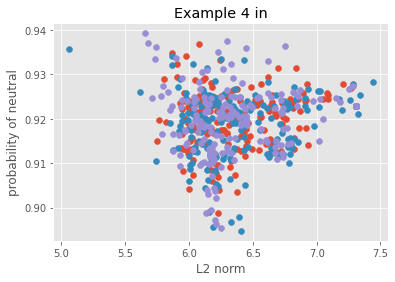

['Ġwritten', '</s>', 'Ġthem', 'Ġwater', '"'] 



100%|██████████| 200/200 [00:45<00:00,  4.43it/s]


['Ġwritten', '</s>', 'Ġthem', 'Ġwater', '"'] 



100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


['Ġwritten', '</s>', 'Ġthem', 'Ġwater', '"'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]

| Min: 0.0
Token: Ġthem | attention: 0.008365690005108206
Token: Ġwritten | attention: 0.007813033482222623
Token: </s> | attention: 0.007422300327862615
Token: " | attention: 0.0067748922468819734
Token: Ġwater | attention: 0.00675826883968035


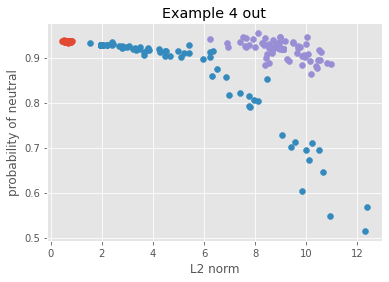





###### Example : 1 label neutral ########
['<pad>', '</s>', 'Ġsibling', 'Ġolder', 'Ġor'] 



100%|██████████| 200/200 [00:45<00:00,  4.36it/s]


['<pad>', '</s>', 'Ġsibling', 'Ġolder', 'Ġor'] 



100%|██████████| 200/200 [00:46<00:00,  4.33it/s]


['<pad>', '</s>', 'Ġsibling', 'Ġolder', 'Ġor'] 



100%|██████████| 200/200 [00:45<00:00,  4.40it/s]

| Min: 0.0
Token: <pad> | attention: 0.004192839007657943
Token: </s> | attention: 0.0
Token: Ġsibling | attention: 0.0
Token: Ġolder | attention: 0.0
Token: Ġor | attention: 0.0


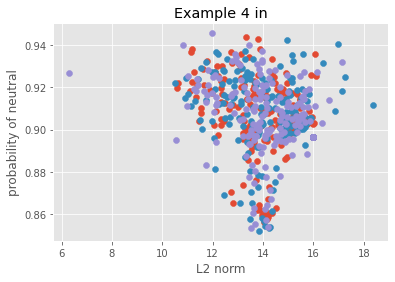

['Ġsibling', 'Ġhike', 'Ġgoing', 'Ġor', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


['Ġsibling', 'Ġhike', 'Ġgoing', 'Ġor', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


['Ġsibling', 'Ġhike', 'Ġgoing', 'Ġor', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]

| Min: 0.0
Token: </s> | attention: 0.0006126589322986624
Token: Ġsibling | attention: 0.000373477958953447
Token: Ġor | attention: 0.00035669174222676455
Token: Ġgoing | attention: 0.00032533179357249314
Token: Ġhike | attention: 0.00029981521204518175


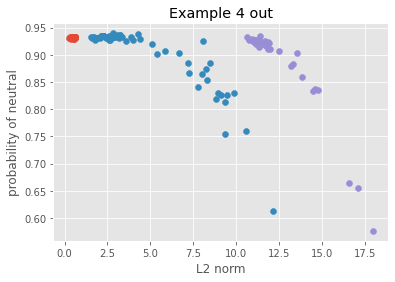





###### Example : 2 label neutral ########
['Ġchild', 'Ġon', 'Ġlooks', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:35<00:00,  5.71it/s]


['Ġchild', 'Ġon', 'Ġlooks', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:35<00:00,  5.70it/s]


['Ġchild', 'Ġon', 'Ġlooks', '<pad>', '</s>'] 



100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


| Min: 0.0
Token: <pad> | attention: 0.0043860642729686315
Token: </s> | attention: 0.0
Token: Ġon | attention: 0.0
Token: Ġlooks | attention: 0.0
Token: Ġchild | attention: 0.0


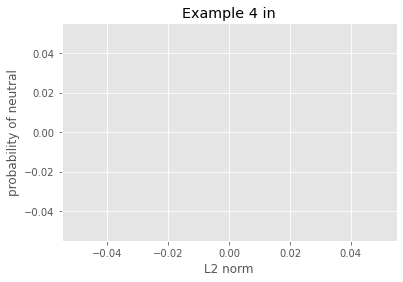

['Ġchild', 'Ġon', '</s>', 'Ġa', 'Ġlooks'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


['Ġchild', 'Ġon', '</s>', 'Ġa', 'Ġlooks'] 



100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


['Ġchild', 'Ġon', '</s>', 'Ġa', 'Ġlooks'] 



100%|██████████| 200/200 [00:22<00:00,  8.93it/s]


| Min: 0.0
Token: Ġon | attention: 0.000669868205199073
Token: </s> | attention: 0.0005697980819052496
Token: Ġlooks | attention: 0.000558403797093893
Token: Ġchild | attention: 0.0005055302115370026
Token: Ġa | attention: 0.0004045256294779393


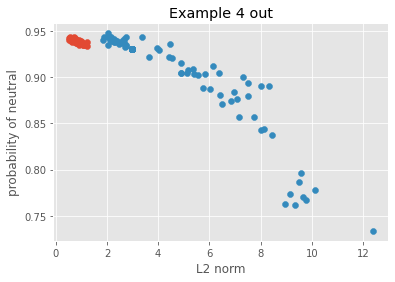

<Figure size 432x288 with 0 Axes>

In [ ]:

mask_out_top5(text[0], "neutral", 0, "L2")





###### Example : 0 label entailment ########
['.', 'Ġon', 'Ġface', 'Ġexpression', '</s>'] 



100%|██████████| 200/200 [00:33<00:00,  5.92it/s]


['.', 'Ġon', 'Ġface', 'Ġexpression', '</s>'] 



100%|██████████| 200/200 [00:34<00:00,  5.86it/s]


['.', 'Ġon', 'Ġface', 'Ġexpression', '</s>'] 



100%|██████████| 200/200 [00:33<00:00,  5.89it/s]


| Min: 0.0
Token: </s> | attention: 0.013718947843507131
Token: . | attention: 0.008241277729654863
Token: Ġface | attention: 0.006252015546456673
Token: Ġexpression | attention: 0.006240129861762876
Token: Ġon | attention: 0.006176586716692152


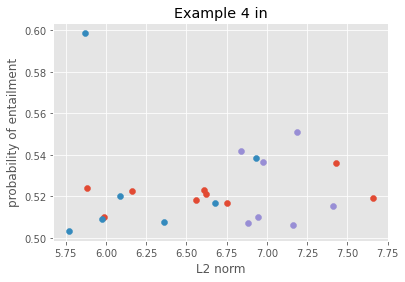

['Ġface', 'Ġon', 'Ġan', '</s>', '.'] 



100%|██████████| 200/200 [00:33<00:00,  6.01it/s]


['Ġface', 'Ġon', 'Ġan', '</s>', '.'] 



100%|██████████| 200/200 [00:33<00:00,  5.93it/s]


['Ġface', 'Ġon', 'Ġan', '</s>', '.'] 



100%|██████████| 200/200 [00:22<00:00,  9.07it/s]


| Min: 0.0
Token: Ġon | attention: 0.008675823196787584
Token: Ġface | attention: 0.008564256060012997
Token: </s> | attention: 0.007878672884405356
Token: Ġan | attention: 0.00635063825889004
Token: . | attention: 0.00552349126365735


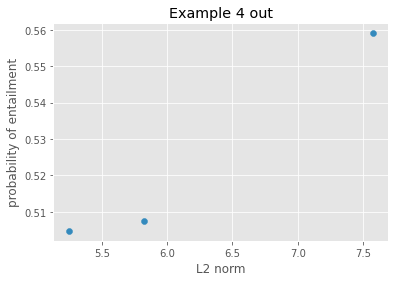





###### Example : 1 label entailment ########
['</s>', '.', 'Ġpile', '<pad>', 'Ġof'] 



100%|██████████| 200/200 [00:34<00:00,  5.79it/s]


['</s>', '.', 'Ġpile', '<pad>', 'Ġof'] 



100%|██████████| 200/200 [00:34<00:00,  5.76it/s]


['</s>', '.', 'Ġpile', '<pad>', 'Ġof'] 



100%|██████████| 200/200 [00:34<00:00,  5.81it/s]


| Min: 0.0
Token: <pad> | attention: 0.0029923312209141567
Token: </s> | attention: 0.0
Token: . | attention: 0.0
Token: Ġof | attention: 0.0
Token: Ġpile | attention: 0.0


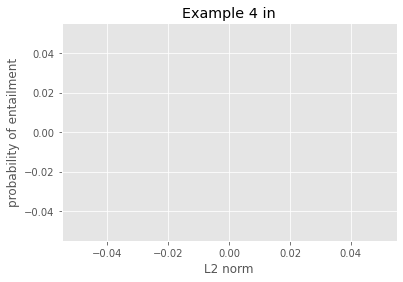

['Ġpile', 'Ġa', '.', '</s>', 'Ġdeep'] 



100%|██████████| 200/200 [00:33<00:00,  5.99it/s]


['Ġpile', 'Ġa', '.', '</s>', 'Ġdeep'] 



100%|██████████| 200/200 [00:33<00:00,  5.97it/s]


['Ġpile', 'Ġa', '.', '</s>', 'Ġdeep'] 



100%|██████████| 200/200 [00:22<00:00,  9.02it/s]


| Min: 0.0
Token: Ġdeep | attention: 0.0005515614252302376
Token: Ġpile | attention: 0.00042787139486350845
Token: </s> | attention: 0.00042064995868223797
Token: Ġa | attention: 0.00035739237632117116
Token: . | attention: 0.0003332336626666264


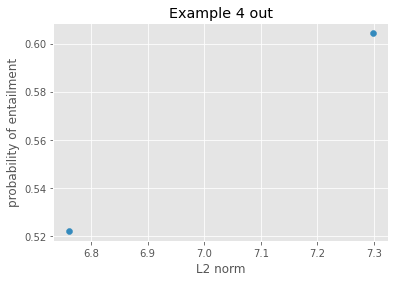





###### Example : 2 label entailment ########
['Ġd', 'une', '<pad>', '</s>', 'Ġdirt'] 



100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


['Ġd', 'une', '<pad>', '</s>', 'Ġdirt'] 



100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


['Ġd', 'une', '<pad>', '</s>', 'Ġdirt'] 



100%|██████████| 200/200 [00:44<00:00,  4.47it/s]

| Min: 0.0
Token: <pad> | attention: 0.0031230417930599
Token: </s> | attention: 0.0013534650570862059
Token: une | attention: 0.0
Token: Ġd | attention: 0.0
Token: Ġdirt | attention: 0.0


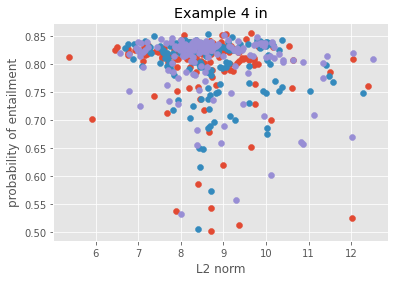

['Ġ', 'Ġd', '</s>', '.', 'une'] 



100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


['Ġ', 'Ġd', '</s>', '.', 'une'] 



100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


['Ġ', 'Ġd', '</s>', '.', 'une'] 



100%|██████████| 200/200 [00:22<00:00,  8.97it/s]


| Min: 0.0
Token: </s> | attention: 0.002023744415725795
Token: une | attention: 0.0006372301860372569
Token: Ġd | attention: 0.0006331131060188041
Token: . | attention: 0.0003120458831910889
Token: Ġ | attention: 0.0003066460040885835


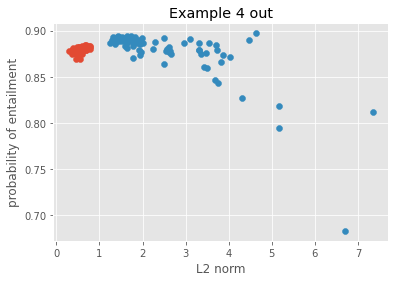

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[1], "entailment", 1, "L2",)





###### Example : 0 label contradiction ########
['<pad>', 'y', '</s>', 'Ġrunning', 'Ġfield'] 



100%|██████████| 200/200 [00:45<00:00,  4.41it/s]


['<pad>', 'y', '</s>', 'Ġrunning', 'Ġfield'] 



100%|██████████| 200/200 [00:45<00:00,  4.42it/s]


['<pad>', 'y', '</s>', 'Ġrunning', 'Ġfield'] 



100%|██████████| 200/200 [00:45<00:00,  4.43it/s]

| Min: 0.0
Token: <pad> | attention: 0.004325559321084372
Token: </s> | attention: 0.0
Token: Ġfield | attention: 0.0
Token: y | attention: 0.0
Token: Ġrunning | attention: 0.0


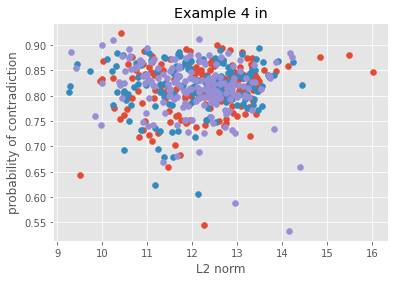

['Ġare', 'Ġmen', 'Ġfield', '</s>', 'y'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


['Ġare', 'Ġmen', 'Ġfield', '</s>', 'y'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['Ġare', 'Ġmen', 'Ġfield', '</s>', 'y'] 



100%|██████████| 200/200 [00:22<00:00,  9.02it/s]


| Min: 0.0
Token: </s> | attention: 0.0005902037086215557
Token: Ġfield | attention: 0.0005106212104472397
Token: y | attention: 0.00043504439803768467
Token: Ġmen | attention: 0.00042464536987546546
Token: Ġare | attention: 0.00036382017195123943


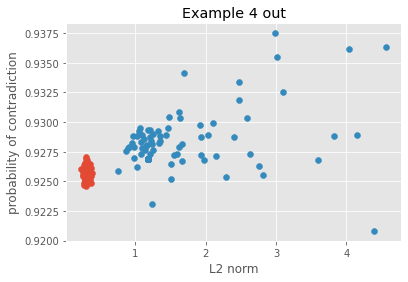





###### Example : 1 label contradiction ########
['</s>', 'Ġabout', 'Ġget', '<pad>', 'Ġto'] 



100%|██████████| 200/200 [00:44<00:00,  4.47it/s]


['</s>', 'Ġabout', 'Ġget', '<pad>', 'Ġto'] 



100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


['</s>', 'Ġabout', 'Ġget', '<pad>', 'Ġto'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]

| Min: 0.0
Token: Ġabout | attention: 0.013078293711889618
Token: </s> | attention: 0.010575475463831611
Token: <pad> | attention: 0.010373741164883122
Token: Ġto | attention: 0.009226793776102336
Token: Ġget | attention: 0.00664563653247808


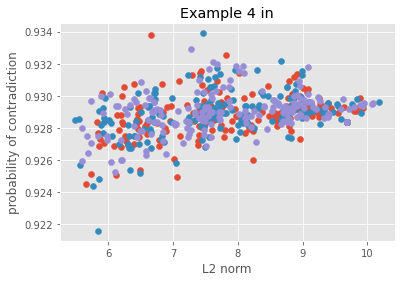

['Ġto', 'Ġorange', 'Ġand', 'Ġkicked', 'Ġget'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


['Ġto', 'Ġorange', 'Ġand', 'Ġkicked', 'Ġget'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['Ġto', 'Ġorange', 'Ġand', 'Ġkicked', 'Ġget'] 



100%|██████████| 200/200 [00:22<00:00,  9.00it/s]


| Min: 0.0
Token: Ġkicked | attention: 0.010405171452290687
Token: Ġorange | attention: 0.00821064341242981
Token: Ġget | attention: 0.007812615799083013
Token: Ġto | attention: 0.00680656039799095
Token: Ġand | attention: 0.006611182776013152


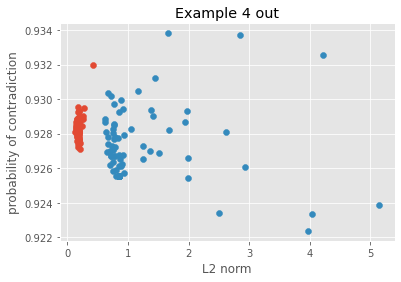





###### Example : 2 label contradiction ########
['Ġfield', '<pad>', '</s>', 'Ġin', 'john'] 



100%|██████████| 200/200 [00:37<00:00,  5.33it/s]


['Ġfield', '<pad>', '</s>', 'Ġin', 'john'] 



100%|██████████| 200/200 [00:38<00:00,  5.16it/s]


['Ġfield', '<pad>', '</s>', 'Ġin', 'john'] 



100%|██████████| 200/200 [00:38<00:00,  5.24it/s]

| Min: 0.0
Token: <pad> | attention: 0.004627352207087663
Token: </s> | attention: 0.0
Token: Ġfield | attention: 0.0
Token: Ġin | attention: 0.0
Token: john | attention: 0.0


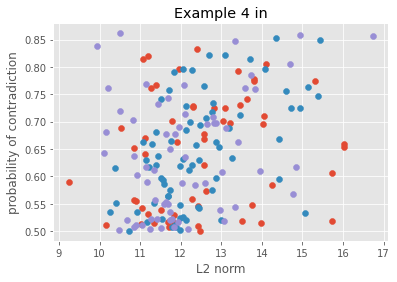

['</s>', 'john', 'Ġin', 'Ġa', 'Ġfield'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


['</s>', 'john', 'Ġin', 'Ġa', 'Ġfield'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


['</s>', 'john', 'Ġin', 'Ġa', 'Ġfield'] 



100%|██████████| 200/200 [00:22<00:00,  9.02it/s]


| Min: 0.0
Token: john | attention: 0.0006493476544622006
Token: Ġin | attention: 0.0006081721760788061
Token: </s> | attention: 0.0005137257847775339
Token: Ġfield | attention: 0.00048584867843719915
Token: Ġa | attention: 0.0003618004189136651


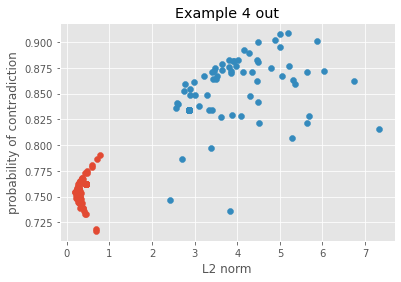

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[2], "contradiction", 2, "L2",)





###### Example : 0 label neutral ########
['</s>', 'Ġbody', 'Cr', 'usher', 'Ġthem'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['</s>', 'Ġbody', 'Cr', 'usher', 'Ġthem'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['</s>', 'Ġbody', 'Cr', 'usher', 'Ġthem'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]

| Min: 0.0
Token: Ġthem | attention: 0.009783648896267616
Token: </s> | attention: 0.00931539894536904
Token: Cr | attention: 0.00787005741029453
Token: usher | attention: 0.006728209822996471
Token: Ġbody | attention: 0.006552573153819083


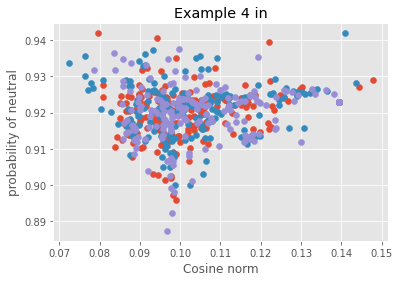

['Ġwater', 'Ġthem', 'Ġwritten', '"', '</s>'] 



100%|██████████| 200/200 [00:43<00:00,  4.55it/s]


['Ġwater', 'Ġthem', 'Ġwritten', '"', '</s>'] 



100%|██████████| 200/200 [00:43<00:00,  4.56it/s]


['Ġwater', 'Ġthem', 'Ġwritten', '"', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]

| Min: 0.0
Token: Ġthem | attention: 0.008365690005108206
Token: Ġwritten | attention: 0.007813033482222623
Token: </s> | attention: 0.007422300327862615
Token: " | attention: 0.0067748922468819734
Token: Ġwater | attention: 0.00675826883968035


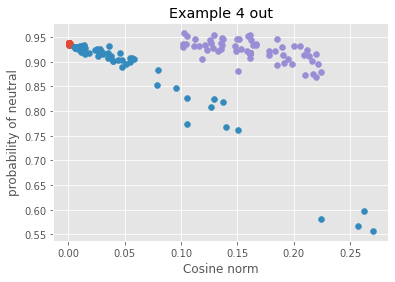





###### Example : 1 label neutral ########
['<pad>', '</s>', 'Ġor', 'Ġolder', 'Ġsibling'] 



100%|██████████| 200/200 [00:46<00:00,  4.33it/s]


['<pad>', '</s>', 'Ġor', 'Ġolder', 'Ġsibling'] 



100%|██████████| 200/200 [00:45<00:00,  4.37it/s]


['<pad>', '</s>', 'Ġor', 'Ġolder', 'Ġsibling'] 



100%|██████████| 200/200 [00:45<00:00,  4.37it/s]

| Min: 0.0
Token: <pad> | attention: 0.004192839007657943
Token: </s> | attention: 0.0
Token: Ġsibling | attention: 0.0
Token: Ġolder | attention: 0.0
Token: Ġor | attention: 0.0


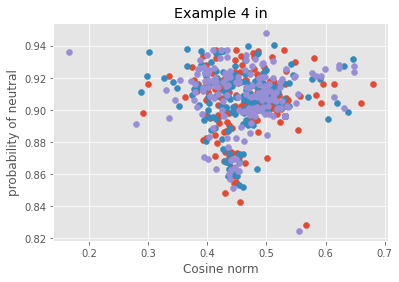

['Ġsibling', 'Ġhike', 'Ġor', 'Ġgoing', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


['Ġsibling', 'Ġhike', 'Ġor', 'Ġgoing', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.54it/s]


['Ġsibling', 'Ġhike', 'Ġor', 'Ġgoing', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]

| Min: 0.0
Token: </s> | attention: 0.0006126589322986624
Token: Ġsibling | attention: 0.000373477958953447
Token: Ġor | attention: 0.00035669174222676455
Token: Ġgoing | attention: 0.00032533179357249314
Token: Ġhike | attention: 0.00029981521204518175


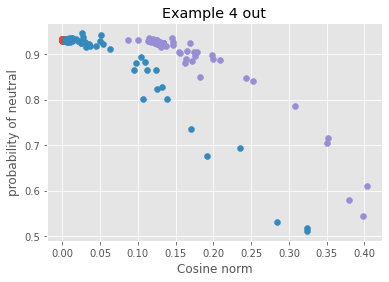





###### Example : 2 label neutral ########
['Ġon', 'Ġchild', '</s>', 'Ġlooks', '<pad>'] 



100%|██████████| 200/200 [00:34<00:00,  5.73it/s]


['Ġon', 'Ġchild', '</s>', 'Ġlooks', '<pad>'] 



100%|██████████| 200/200 [00:34<00:00,  5.75it/s]


['Ġon', 'Ġchild', '</s>', 'Ġlooks', '<pad>'] 



100%|██████████| 200/200 [00:34<00:00,  5.74it/s]


| Min: 0.0
Token: <pad> | attention: 0.0043860642729686315
Token: </s> | attention: 0.0
Token: Ġon | attention: 0.0
Token: Ġlooks | attention: 0.0
Token: Ġchild | attention: 0.0


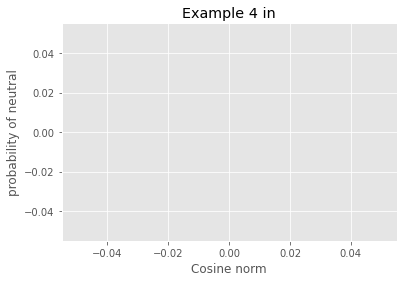

['Ġchild', '</s>', 'Ġon', 'Ġa', 'Ġlooks'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


['Ġchild', '</s>', 'Ġon', 'Ġa', 'Ġlooks'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['Ġchild', '</s>', 'Ġon', 'Ġa', 'Ġlooks'] 



100%|██████████| 200/200 [00:22<00:00,  8.89it/s]


| Min: 0.0
Token: Ġon | attention: 0.000669868205199073
Token: </s> | attention: 0.0005697980819052496
Token: Ġlooks | attention: 0.000558403797093893
Token: Ġchild | attention: 0.0005055302115370026
Token: Ġa | attention: 0.0004045256294779393


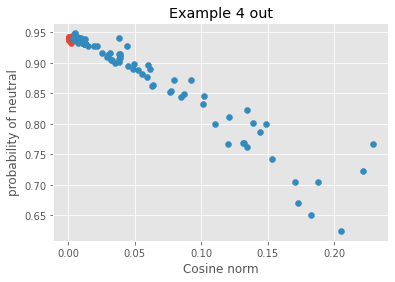

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[0], "neutral", 0, "Cosine")





###### Example : 0 label entailment ########
['</s>', 'Ġon', '.', 'Ġexpression', 'Ġface'] 



100%|██████████| 200/200 [00:33<00:00,  5.91it/s]


['</s>', 'Ġon', '.', 'Ġexpression', 'Ġface'] 



100%|██████████| 200/200 [00:33<00:00,  5.90it/s]


['</s>', 'Ġon', '.', 'Ġexpression', 'Ġface'] 



100%|██████████| 200/200 [00:33<00:00,  5.90it/s]


| Min: 0.0
Token: </s> | attention: 0.013718947843507131
Token: . | attention: 0.008241277729654863
Token: Ġface | attention: 0.006252015546456673
Token: Ġexpression | attention: 0.006240129861762876
Token: Ġon | attention: 0.006176586716692152


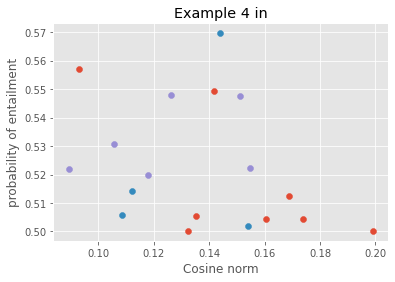

['</s>', 'Ġface', 'Ġon', '.', 'Ġan'] 



100%|██████████| 200/200 [00:33<00:00,  6.02it/s]


['</s>', 'Ġface', 'Ġon', '.', 'Ġan'] 



100%|██████████| 200/200 [00:33<00:00,  5.89it/s]


['</s>', 'Ġface', 'Ġon', '.', 'Ġan'] 



100%|██████████| 200/200 [00:22<00:00,  9.03it/s]


| Min: 0.0
Token: Ġon | attention: 0.008675823196787584
Token: Ġface | attention: 0.008564256060012997
Token: </s> | attention: 0.007878672884405356
Token: Ġan | attention: 0.00635063825889004
Token: . | attention: 0.00552349126365735


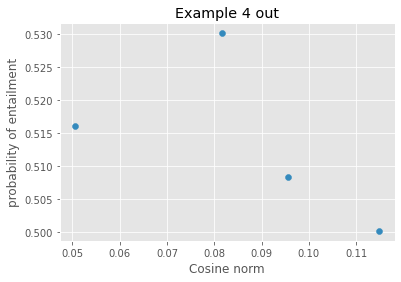





###### Example : 1 label entailment ########
['Ġof', '</s>', '.', '<pad>', 'Ġpile'] 



100%|██████████| 200/200 [00:34<00:00,  5.77it/s]


['Ġof', '</s>', '.', '<pad>', 'Ġpile'] 



100%|██████████| 200/200 [00:34<00:00,  5.82it/s]


['Ġof', '</s>', '.', '<pad>', 'Ġpile'] 



100%|██████████| 200/200 [00:34<00:00,  5.85it/s]


| Min: 0.0
Token: <pad> | attention: 0.0029923312209141567
Token: </s> | attention: 0.0
Token: . | attention: 0.0
Token: Ġof | attention: 0.0
Token: Ġpile | attention: 0.0


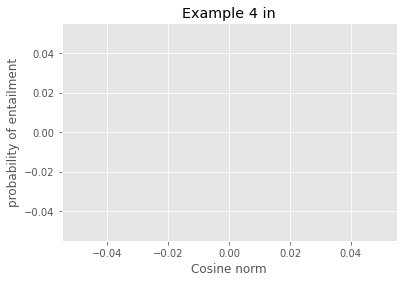

['</s>', '.', 'Ġa', 'Ġdeep', 'Ġpile'] 



100%|██████████| 200/200 [00:33<00:00,  5.97it/s]


['</s>', '.', 'Ġa', 'Ġdeep', 'Ġpile'] 



100%|██████████| 200/200 [00:33<00:00,  6.05it/s]


['</s>', '.', 'Ġa', 'Ġdeep', 'Ġpile'] 



100%|██████████| 200/200 [00:22<00:00,  8.98it/s]


| Min: 0.0
Token: Ġdeep | attention: 0.0005515614252302376
Token: Ġpile | attention: 0.00042787139486350845
Token: </s> | attention: 0.00042064995868223797
Token: Ġa | attention: 0.00035739237632117116
Token: . | attention: 0.0003332336626666264


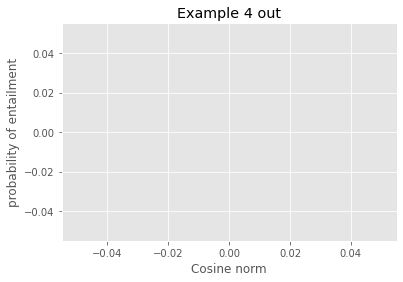





###### Example : 2 label entailment ########
['une', '<pad>', 'Ġdirt', '</s>', 'Ġd'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['une', '<pad>', 'Ġdirt', '</s>', 'Ġd'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


['une', '<pad>', 'Ġdirt', '</s>', 'Ġd'] 



100%|██████████| 200/200 [00:44<00:00,  4.47it/s]

| Min: 0.0
Token: <pad> | attention: 0.0031230417930599
Token: </s> | attention: 0.0013534650570862059
Token: une | attention: 0.0
Token: Ġd | attention: 0.0
Token: Ġdirt | attention: 0.0


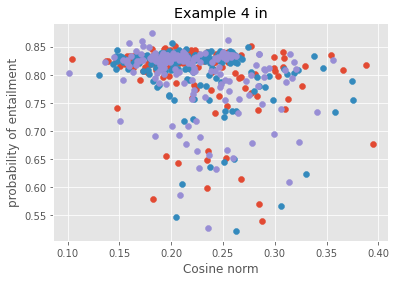

['une', '.', 'Ġd', 'Ġ', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.49it/s]


['une', '.', 'Ġd', 'Ġ', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.53it/s]


['une', '.', 'Ġd', 'Ġ', '</s>'] 



100%|██████████| 200/200 [00:22<00:00,  9.02it/s]


| Min: 0.0
Token: </s> | attention: 0.002023744415725795
Token: une | attention: 0.0006372301860372569
Token: Ġd | attention: 0.0006331131060188041
Token: . | attention: 0.0003120458831910889
Token: Ġ | attention: 0.0003066460040885835


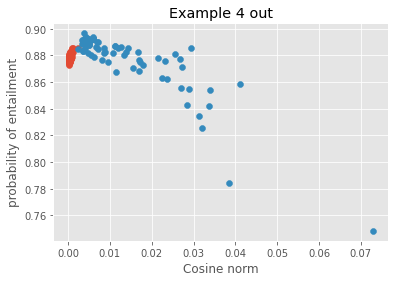

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[1], "entailment", 1, "Cosine",)





###### Example : 0 label contradiction ########
['</s>', 'y', 'Ġfield', 'Ġrunning', '<pad>'] 



100%|██████████| 200/200 [00:44<00:00,  4.45it/s]


['</s>', 'y', 'Ġfield', 'Ġrunning', '<pad>'] 



100%|██████████| 200/200 [00:45<00:00,  4.39it/s]


['</s>', 'y', 'Ġfield', 'Ġrunning', '<pad>'] 



100%|██████████| 200/200 [00:44<00:00,  4.46it/s]

| Min: 0.0
Token: <pad> | attention: 0.004325559321084372
Token: </s> | attention: 0.0
Token: Ġfield | attention: 0.0
Token: y | attention: 0.0
Token: Ġrunning | attention: 0.0


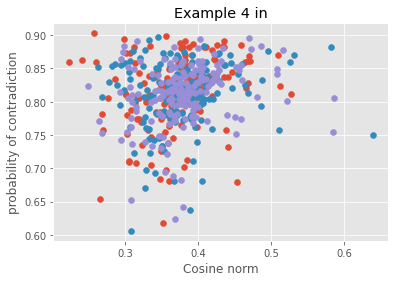

['y', 'Ġare', 'Ġfield', 'Ġmen', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


['y', 'Ġare', 'Ġfield', 'Ġmen', '</s>'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['y', 'Ġare', 'Ġfield', 'Ġmen', '</s>'] 



100%|██████████| 200/200 [00:22<00:00,  9.05it/s]


| Min: 0.0
Token: </s> | attention: 0.0005902037086215557
Token: Ġfield | attention: 0.0005106212104472397
Token: y | attention: 0.00043504439803768467
Token: Ġmen | attention: 0.00042464536987546546
Token: Ġare | attention: 0.00036382017195123943


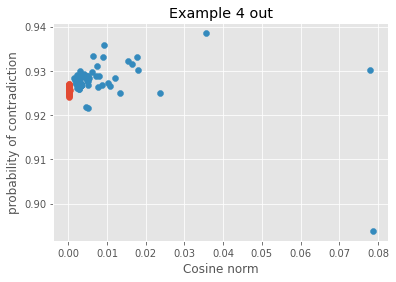





###### Example : 1 label contradiction ########
['Ġget', '</s>', '<pad>', 'Ġto', 'Ġabout'] 



100%|██████████| 200/200 [00:44<00:00,  4.50it/s]


['Ġget', '</s>', '<pad>', 'Ġto', 'Ġabout'] 



100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


['Ġget', '</s>', '<pad>', 'Ġto', 'Ġabout'] 



100%|██████████| 200/200 [00:44<00:00,  4.47it/s]

| Min: 0.0
Token: Ġabout | attention: 0.013078293711889618
Token: </s> | attention: 0.010575475463831611
Token: <pad> | attention: 0.010373741164883122
Token: Ġto | attention: 0.009226793776102336
Token: Ġget | attention: 0.00664563653247808


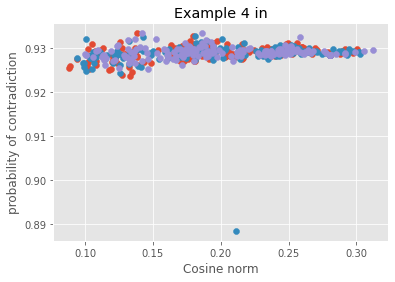

['Ġto', 'Ġget', 'Ġand', 'Ġorange', 'Ġkicked'] 



100%|██████████| 200/200 [00:44<00:00,  4.52it/s]


['Ġto', 'Ġget', 'Ġand', 'Ġorange', 'Ġkicked'] 



100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


['Ġto', 'Ġget', 'Ġand', 'Ġorange', 'Ġkicked'] 



100%|██████████| 200/200 [00:22<00:00,  8.95it/s]


| Min: 0.0
Token: Ġkicked | attention: 0.010405171452290687
Token: Ġorange | attention: 0.00821064341242981
Token: Ġget | attention: 0.007812615799083013
Token: Ġto | attention: 0.00680656039799095
Token: Ġand | attention: 0.006611182776013152


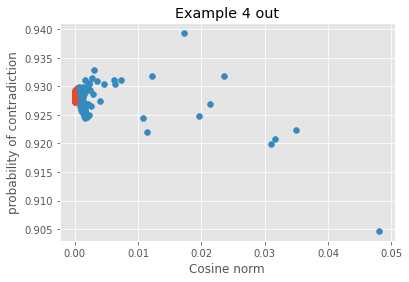





###### Example : 2 label contradiction ########
['john', 'Ġfield', 'Ġin', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:38<00:00,  5.17it/s]


['john', 'Ġfield', 'Ġin', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:38<00:00,  5.19it/s]


['john', 'Ġfield', 'Ġin', '</s>', '<pad>'] 



100%|██████████| 200/200 [00:38<00:00,  5.23it/s]


| Min: 0.0
Token: <pad> | attention: 0.004627352207087663
Token: </s> | attention: 0.0
Token: Ġfield | attention: 0.0
Token: Ġin | attention: 0.0
Token: john | attention: 0.0


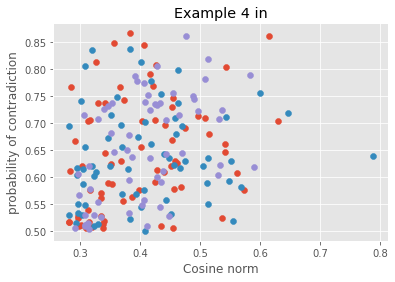

['john', 'Ġfield', '</s>', 'Ġin', 'Ġa'] 



100%|██████████| 200/200 [00:45<00:00,  4.44it/s]


['john', 'Ġfield', '</s>', 'Ġin', 'Ġa'] 



100%|██████████| 200/200 [00:44<00:00,  4.51it/s]


['john', 'Ġfield', '</s>', 'Ġin', 'Ġa'] 



100%|██████████| 200/200 [00:22<00:00,  8.99it/s]


| Min: 0.0
Token: john | attention: 0.0006493476544622006
Token: Ġin | attention: 0.0006081721760788061
Token: </s> | attention: 0.0005137257847775339
Token: Ġfield | attention: 0.00048584867843719915
Token: Ġa | attention: 0.0003618004189136651


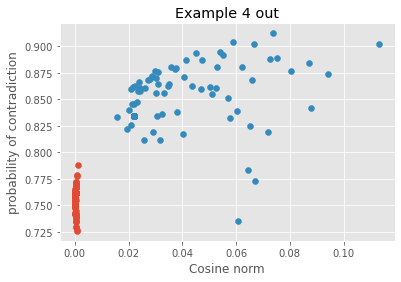

<Figure size 432x288 with 0 Axes>

In [ ]:
mask_out_top5(text[2], "contradiction", 2, "Cosine",)

In [ ]:
select_max_imp = 100

In [ ]:
def calculate_imp(true_logits, true_class, perturbed_logits, perturbed_class):
  if(perturbed_class == true_class):
    return true_logits[true_class] - perturbed_logits[true_class]
  return true_logits[true_class] - perturbed_logits[true_class] + true_logits[perturbed_class] - perturbed_logits[perturbed_class]

In [ ]:
print(tokenizer.decode([1532]))

 learn


In [ ]:
def intersection(a, b):
  cnt = 0;
  print(a)
  print(b)
  for i in range(min(len(a), len(b))):
      if(a[i] == b[i]):
          cnt += 1;
      
  return (cnt/min(len(a), len(b)))*100

In [ ]:
def find_intersection_top5(text_lab, label, label_ind, flag):
    accumulate_over = 4
    global cnt, temp_attention, manager;
    optimizer.zero_grad()

    for i, (tokens, tokenized_threads) in enumerate(text_lab):
        print("\n\n\n")
        print("###### Example :", str(i), "label", label, "########")
        #Cast to PyTorch tensor
        tokenized_threads = torch.tensor(tokenized_threads, device=device).reshape((1, len(tokenized_threads)))
        
        pad_mask = torch.where(tokenized_threads!=tokenizer.pad_token_id, 1, 0)
        
        attention = transformer_model(input_ids=tokenized_threads,
                                            attention_mask=pad_mask,)[-1][0].cpu().detach().numpy()
        graph = dict()
        
        for tok in tokens:
            if(tok not in mapping_ind):
                mapping_ind[tok] = cnt;
                cnt += 1

        for lay in range(12):
            weights = attention[0, lay, :, :]
            for ind_1 in range(len(tokens)):
                for ind_2 in range(len(tokens)):
                    if(tokens[ind_1] in ["[NEWLINE]", '[PAD]'] or tokens[ind_2] in ["[NEWLINE]", '[PAD]']):
                        continue
                    node_1 = mapping_ind[tokens[ind_1]]
                    node_2 = mapping_ind[tokens[ind_2]]
                    rev_mapping_ind[node_1] = tokens[ind_1]
                    rev_mapping_ind[node_2] = tokens[ind_2]
                    weight = weights[ind_1, ind_2]
                    if(node_1 not in graph):
                        graph[node_1] = {}
                    if(node_2  not in graph[node_1]):
                        graph[node_1][node_2] = (weight, 1)
                    else:
                        graph[node_1][node_2] = ((weight + (graph[node_1][node_2][0])*graph[node_1][node_2][1])/(graph[node_1][node_2][1] + 1), graph[node_1][node_2][1] + 1)
        logits = predict_proba(tokenized_threads)
        class_assigned = torch.argmax(logits[0, :])
        topk_in, topk_out, topk_in_attention, topk_out_attention, topk_in_min, topk_out_min = find_topk_tokens(graph, select_max_imp)
        arr = tokenized_threads.cpu().detach().clone().numpy()

        candidates = []
        for j in range(len(tokens)):
          temp_tokenized_threads = np.concatenate([arr[0, : j], arr[0, j + 1:], np.array([tokenizer.pad_token_id])])
    
          temp_logits = predict_proba(torch.tensor(temp_tokenized_threads, device=device).reshape((1, len(temp_tokenized_threads))))

          temp_class_assigned = torch.argmax(temp_logits)

          importance_score = calculate_imp(logits[0], class_assigned, temp_logits[0], temp_class_assigned)
          candidates.append((arr[0, j], importance_score))
        candidates.sort(key = lambda x : x[1])
        candidates.reverse()
        print(candidates)
        print("intersection between in : ", intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]", "[SEP]"]], [rev_mapping_ind[z] for z in topk_in]))
        print("intersection between out : ",intersection([tokenizer.decode(i[0]) for i in candidates[:select_max_imp] if tokenizer.decode(i[0]) not in ["[CLS]", "[PAD]","[SEP]"]], [rev_mapping_ind[z] for z in topk_out]))

In [ ]:

find_intersection_top5(text[2], "contradiction", 2, "Cosine",)





###### Example : 0 label contradiction ########
[(878, tensor(0.0958, device='cuda:0', grad_fn=<SubBackward0>)), (83, tensor(0.0255, device='cuda:0', grad_fn=<SubBackward0>)), (6476, tensor(0.0163, device='cuda:0', grad_fn=<SubBackward0>)), (50265, tensor(0.0148, device='cuda:0', grad_fn=<SubBackward0>)), (0, tensor(0.0133, device='cuda:0', grad_fn=<SubBackward0>)), (1437, tensor(0.0066, device='cuda:0', grad_fn=<SubBackward0>)), (1003, tensor(0.0064, device='cuda:0', grad_fn=<SubBackward0>)), (30, tensor(0.0041, device='cuda:0', grad_fn=<SubBackward0>)), (882, tensor(0.0027, device='cuda:0', grad_fn=<SubBackward0>)), (6964, tensor(0.0027, device='cuda:0', grad_fn=<SubBackward0>)), (2600, tensor(0.0026, device='cuda:0', grad_fn=<SubBackward0>)), (83, tensor(0.0021, device='cuda:0', grad_fn=<SubBackward0>)), (4, tensor(0.0021, device='cuda:0', grad_fn=<SubBackward0>)), (10, tensor(0.0014, device='cuda:0', grad_fn=<SubBackward0>)), (1437, tensor(0.0012, device='cuda:0', grad_fn=<SubB

In [ ]:
find_intersection_top5(text[1], "entailment", 1, "L2",)





###### Example : 0 label entailment ########
[(41, tensor(0.0399, device='cuda:0', grad_fn=<SubBackward0>)), (2828, tensor(0.0286, device='cuda:0', grad_fn=<SubBackward0>)), (2473, tensor(0.0048, device='cuda:0', grad_fn=<SubBackward0>)), (2, tensor(0.0023, device='cuda:0', grad_fn=<SubBackward0>)), (16, tensor(-0.0006, device='cuda:0', grad_fn=<SubBackward0>)), (3428, tensor(-0.0009, device='cuda:0', grad_fn=<SubBackward0>)), (1437, tensor(-0.0031, device='cuda:0', grad_fn=<SubBackward0>)), (10, tensor(-0.0045, device='cuda:0', grad_fn=<SubBackward0>)), (11, tensor(-0.0045, device='cuda:0', grad_fn=<SubBackward0>)), (11, tensor(-0.0051, device='cuda:0', grad_fn=<SubBackward0>)), (83, tensor(-0.0086, device='cuda:0', grad_fn=<SubBackward0>)), (15, tensor(-0.0105, device='cuda:0', grad_fn=<SubBackward0>)), (69, tensor(-0.0154, device='cuda:0', grad_fn=<SubBackward0>)), (0, tensor(-0.0168, device='cuda:0', grad_fn=<SubBackward0>)), (8151, tensor(-0.0171, device='cuda:0', grad_fn=<Sub

In [ ]:
find_intersection_top5(text[0], "neutral", 0, "L2")





###### Example : 0 label neutral ########
[(22282, tensor(0.3132, device='cuda:0', grad_fn=<SubBackward0>)), (2828, tensor(0.1524, device='cuda:0', grad_fn=<SubBackward0>)), (2399, tensor(0.0704, device='cuda:0', grad_fn=<SubBackward0>)), (514, tensor(0.0623, device='cuda:0', grad_fn=<SubBackward0>)), (39749, tensor(0.0602, device='cuda:0', grad_fn=<SubBackward0>)), (1692, tensor(0.0478, device='cuda:0', grad_fn=<SubBackward0>)), (604, tensor(0.0359, device='cuda:0', grad_fn=<SubBackward0>)), (50265, tensor(0.0212, device='cuda:0', grad_fn=<SubBackward0>)), (0, tensor(0.0192, device='cuda:0', grad_fn=<SubBackward0>)), (1596, tensor(0.0131, device='cuda:0', grad_fn=<SubBackward0>)), (11, tensor(0.0051, device='cuda:0', grad_fn=<SubBackward0>)), (4, tensor(0.0050, device='cuda:0', grad_fn=<SubBackward0>)), (1596, tensor(0.0042, device='cuda:0', grad_fn=<SubBackward0>)), (32, tensor(0.0040, device='cuda:0', grad_fn=<SubBackward0>)), (8, tensor(0.0039, device='cuda:0', grad_fn=<SubBack